In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cicTools import *
from scipy import spatial
import configparser
from astropy.io import ascii
import readgadget
import readfof
import redshift_space_library as RSL

config = configparser.ConfigParser()
config.read('config.ini')

write = config['PARAMS'].getboolean('write')            #write files with results
plot = config['PARAMS'].getboolean('plot')              #plot results for checking  

seed = int(config['PARAMS']['seed'])                    #random seed
#lbox = float(config['PARAMS']['lbox'])                 #length of box
ngxs = float(config['PARAMS']['ngxs'])                  #dilution
zspace = config['PARAMS'].getboolean('zspace')          #redshift space
zspaceAxis = config['PARAMS']['zspaceAxis']             #r-space axis
nesf = int(config['PARAMS']['nesf'])                    #num of test spheres
rsbin = int(config['PARAMS']['rsbin'])                  #num of bins of r
jk = int(config['PARAMS']['jk'])                        #cubic root of num of jk resamplings
invoid = config['PARAMS'].getboolean('invoid')          #calculate VPF inside voids
#completeRrange = config['PARAMS'].getboolean('completeRrange')
snap = int(config['PARAMS']['snap'])                    #snapshot number
minmass = float(config['PARAMS']['minmass'])            #log10 of minimum mass
maxmass = float(config['PARAMS']['maxmass'])            #log10 of maximum mass 
minradV = float(config['PARAMS']['minradV'])            #minimum void radius
voidfile = str(config['PARAMS']['voidfile'])            #location of voids file / which voids to use
delta = str(config['PARAMS']['delta'])                  #delta used in void identification
voids_zs = config['PARAMS'].getboolean('voids_zs')      #read voids identified in z-space
evolDelta = config['PARAMS'].getboolean('evolDelta')    #read voids identified with evolved integrated delta



In [2]:

#
#-----------
# Read data from Quijote
#-----------
#
snapdir = '/home/fdavilakurban/mnt/clemente/quijote/Halos/FoF/fiducial/0/' #folder hosting the catalogue
snapnum = 4   
# get the name of the corresponding snapshot
snapshot = '/home/fdavilakurban/mnt/clemente/quijote/Snapshots/fiducial/0/snapdir_%03d/snap_%03d'%(snapnum,snapnum)

# read the redshift, boxsize, cosmology...etc in the header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

print('BoxSize = %.3f Mpc/h'%BoxSize)
print('Number of particles in the snapshot:',Nall)
#print('Omega_m = %.3f'%Omega_m)
#print('Omega_l = %.3f'%Omega_l)
#print('h = %.3f'%h)
print('redshift = %.1f'%redshift)


# read the halo catalogue
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False,
                          swap=False, SFR=False, read_IDs=False)
# get the properties of the halos
gxs = FoF.GroupPos/1e3  #Halo positions in Mpc/h
meansep  = BoxSize/float(len(gxs))**(1./3)
print('mean interparticle separation = %.2f Mpc/h'%meansep)


# get the properties of the halos
pos_h  = FoF.GroupPos/1e3            #Halo positions in Mpc/h
vel_h  = FoF.GroupVel*(1.0+redshift) #Halo peculiar velocities in km/s
mass_h = FoF.GroupMass*1e10          #Halo masses in Msun/h
Np_h   = FoF.GroupLen                #Number of CDM particles in the halo. Even in simulations with massive neutrinos, this will be just the number of CDM particles


BoxSize = 1000.000 Mpc/h
Number of particles in the snapshot: [        0 134217728         0         0         0         0]
redshift = 0.0
mean interparticle separation = 13.50 Mpc/h


In [3]:
rmin, rmax = 3, 30
rs = np.geomspace(rmin,rmax,rsbin)
print('rs: ',rs)
#
#-----------
# Replicate box edges periodically
#-----------
#
print('Replicating box:')
newgxs = perrep_array(gxs,BoxSize,np.max(rs))
print(f'Num of original gxs in box: {len(gxs)}\n\
Num of gxs after replication: {len(newgxs)}')


rs:  [ 3.          4.4033978   6.46330407  9.48683298 13.9247665  20.43876207
 30.        ]
Replicating box:
Num of original gxs in box: 406660
Num of gxs after replication: 484366


In [4]:
#
#-----------
# Distant observer aproximation for z-space
#-----------
#
if zspace == True:
    print('Simulating zspace')
    H0 = .06774
    axis = zspaceAxis
    vaxis = 'v'+axis
    newgxs[axis]+=newgxs[vaxis]/H0
    newgxs[axis][np.where(newgxs[axis]<0.)[0]]+=BoxSize
    newgxs[axis][np.where(newgxs[axis]>BoxSize)[0]]-=BoxSize


In [5]:
#
#-----------
# VPF calculations
#-----------
#
#pos = np.column_stack((newgxs['x'],newgxs['y'],newgxs['z']))

tree = spatial.cKDTree(newgxs)

chi = np.zeros(len(rs))
NXi = np.zeros(len(rs))
P0 = np.zeros(len(rs))
N_mean = np.zeros(len(rs))
xi_mean = np.zeros(len(rs))

if invoid == False:
    if jk!= 0:
        chi_std = np.zeros(len(rs))
        NXi_std = np.zeros(len(rs))
        P0_std = np.zeros(len(rs))
        N_mean_std = np.zeros(len(rs))
        xi_mean_std = np.zeros(len(rs))

        print('Calculating JK cic statistics...')
        
        for i,r in enumerate(rs):
            chi[i], NXi[i], P0[i], N_mean[i], xi_mean[i],\
                    chi_std[i], NXi_std[i], P0_std[i], N_mean_std[i], xi_mean_std[i]\
                        = cic_stats_jk(tree, nesf, r, BoxSize, jk)
    # else:
    #     print('Calculating cic statistics...')
    #     for i,r in enumerate(rs):
    #         chi[i], NXi[i], P0[i], N_mean[i], xi_mean[i],\
    #                     = cic_stats(tree, nesf, r, lbox)


Calculating JK cic statistics...


/media/fdavilakurban/0a842929-67de-4adc-b64c-8bc6d17a08b0/fdavilakurban/Proyectos/VPF_Quijote/codes/cicTools.py:192: RuntimeWarning: divide by zero encountered in log
  chi_jk[i,j,k] = -np.log(P0_jk[i,j,k])/N_mean_jk[i,j,k]
/tmp/ipykernel_9461/1040475267.py:27: UserWarning: Warning: converting a masked element to nan.
  chi[i], NXi[i], P0[i], N_mean[i], xi_mean[i],\
/tmp/ipykernel_9461/1040475267.py:28: UserWarning: Warning: converting a masked element to nan.
  chi_std[i], NXi_std[i], P0_std[i], N_mean_std[i], xi_mean_std[i]\


In [6]:
print(NXi)

[0.18877701 0.4514436  0.87619648 1.5980775  2.73681081 4.46930199
 6.8196401 ]


In [6]:
namefile = f'../data/halos_{rmin}_{rmax}_{rsbin}.npz'

#
#-----------
# Writing file
#-----------

if write==True:
    print(f'Creating {namefile}')
    if jk!=0:
        np.savez(namefile,chi,chi_std,NXi,NXi_std,P0,P0_std,N_mean,N_mean_std,xi_mean,xi_mean_std,rs)
    else:
        np.savez(namefile,chi,NXi,P0,N_mean,xi_mean,rs)

print(chi, rs)

Creating ../data/halos_3_30_7.npz
[0.90923149 0.80948086 0.68992096 0.55479871 0.42980518 0.32550934
        nan] [ 3.          4.4033978   6.46330407  9.48683298 13.9247665  20.43876207
 30.        ]


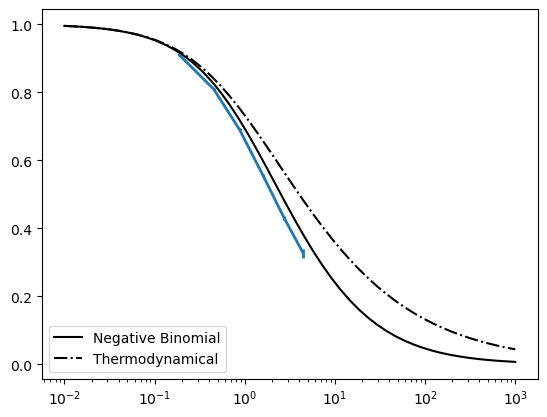

[0.18877701 0.4514436  0.87619648 1.5980775  2.73681081 4.46930199
 6.8196401 ]


In [8]:
if plot==True:
    x = np.geomspace(1E-2,1E3,50)
    c='k'
    #chi = -np.log(P0)/N_mean
    #NE = N_mean*xi_mean

    plt.plot(x,np.log(1+x)/x,label='Negative Binomial',c=c)
    #a=.3
    #plt.plot(x,(1/((1-a)*(x/a)))*((1+x/a)**(1-a)-1),label='Generalized Hierarhichal',c=c,ls='--')
    #plt.plot(x,(1-np.e**(-x))/x,label='Minimal')
    plt.plot(x,(np.sqrt(1+2*x)-1)/x,label='Thermodynamical',c=c,ls='-.')
    #plt.plot(x[:-15],1-x[:-15]/2,label='Gauss',c=c)
    # Q=1
    # plt.plot(x,1-(np.euler_gamma+np.log(4*Q*x))/(8*Q),label='BBGKY',c=c,ls=':')

    if jk==0: plt.plot(NXi,chi,lw=2)
    else: plt.errorbar(NXi,chi,yerr=NXi_std, lw=2)
    plt.xscale('log')
    plt.legend(loc=3)
    plt.show()
print(NXi)

In [12]:
print(newgxs)
print(newgxs[:,0])

[[ 184.29701    779.9311     774.9886   ]
 [ 411.87167    388.3982     873.5964   ]
 [ 612.3167     642.5959     501.4779   ]
 ...
 [ 910.7806     -20.405579  1008.50336  ]
 [ 978.8193     -19.234375  1018.2095   ]
 [ 983.44476     -6.2407837 1028.8431   ]]
[184.29701 411.87167 612.3167  ... 910.7806  978.8193  983.44476]


In [84]:
from Corrfunc.theory.vpf import vpf
numpN=2
seed=42
results_vpf = vpf(rmax, rsbin, nesf, numpN=numpN, seed=seed, X=newgxs[:,0], Y=newgxs[:,1], Z=newgxs[:,2], boxsize=BoxSize)
print(results_vpf)
print(P0)

[( 4.28571429, [0.95398998, 0.036     ])
 ( 8.57142857, [0.77970999, 0.10452   ])
 (12.85714286, [0.57190001, 0.12164   ])
 (17.14285714, [0.39703   , 0.10405999])
 (21.42857143, [0.26306999, 0.08349   ])
 (25.71428571, [0.16109   , 0.06271   ])
 (30.        , [0.08779   , 0.04367   ])]
[0.95845074 0.88712111 0.72703296 0.44493407 0.13824111 0.00871222
 0.        ]


rs:  [ 4.28571429  8.57142857 12.85714286 17.14285714 21.42857143 25.71428571
 30.        ]
2.917866766650704
0.990780845604444
0.3845476362463084
0.16372588097616855
0.07331973065114583
0.03178416543213244
0.012853091488831209
p0CF:  8.571428571428571


Text(0.5, 0, 'r')

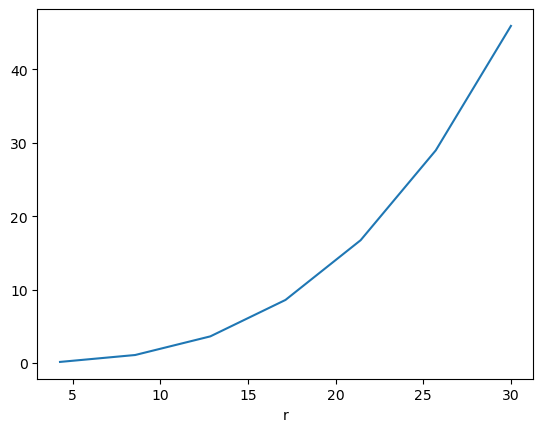

In [111]:

rs = np.linspace(rmax/rsbin,rmax,rsbin)
print('rs: ',rs)


xi = np.zeros(rsbin)
nmean = np.zeros(rsbin)
for i in range(rsbin):
    spheres = (BoxSize)*np.random.rand(nesf,3)

    ngals = tree.query_ball_point(spheres,rs[i],return_length=True)
    #xi[i] = np.var(ngals)
    nmean[i] = np.mean(ngals)

    xi[i] = (np.mean((ngals-nmean[i])**2)-nmean[i])/nmean[i]**2
for i in range(len(results_vpf)):
    print(xi[i]*results_vpf[i][1][0])


[ 0.13176  1.07427  3.61426  8.57906 16.72094 28.9683  45.92899]
[ 0.0466737   0.14796407  0.46205852  1.45968444  4.60386111 14.57139556
 46.04888556]
p0CF:  [0.95398998 0.77970999 0.57190001 0.39703    0.26306999 0.16109
 0.08779   ]


Text(0.5, 0, 'r')

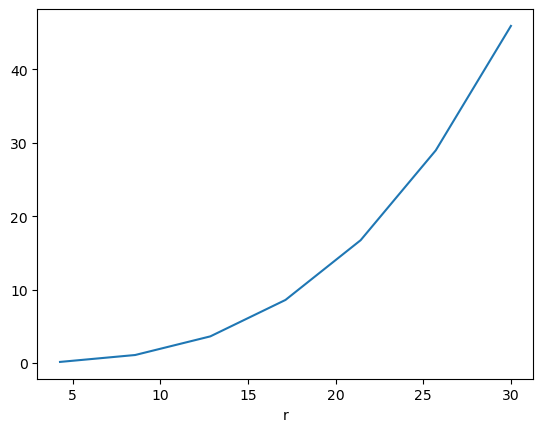

In [123]:
print(nmean)
print(N_mean)

p0CF = np.array([results_vpf[i][1][0] for i in range(len(rs))])

print('p0CF: ',p0CF)
plt.plot(rs,nmean)
plt.xlabel('r')
#plt.ylabel('p0*Xi')

[0.35748412 0.23163007 0.15460734 0.1076742  0.07986005 0.06302724
 0.05296889]
[0.90923149 0.80948086 0.68992096 0.55479871 0.42980518 0.32550934
        nan]


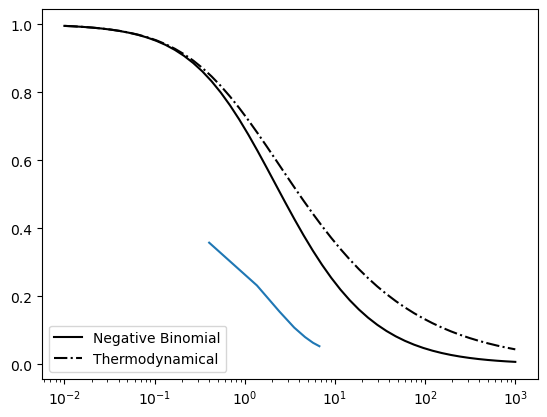

In [121]:

#PLOT
x = np.geomspace(1E-2,1E3,50)
c='k'
plt.plot(x,np.log(1+x)/x,label='Negative Binomial',c=c)
plt.plot(x,(np.sqrt(1+2*x)-1)/x,label='Thermodynamical',c=c,ls='-.')

chiCF = -np.log(p0CF)/nmean
nxiCF = nmean*xi
print(chiCF)
print(chi)
plt.plot(nxiCF,chiCF,c='C00')
plt.xscale('log')
plt.legend(loc=3)
plt.show()

